In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to Open/Close the Code."></form>''')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from joblib import Parallel, delayed

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.sliding_window import SlidingWindow

### Read Data

#### NOTICE: this simulation data here presented was produced inspired in Exemple 3 of the following work:

<cite>WANG, J. et al. Searching historical data segments for process identification in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.</cite>

In [4]:
u = pd.read_csv('siso_simu_u.csv',header=None)
sp = pd.read_csv('siso_simu_sp.csv',header=None)
y = pd.read_csv('siso_simu_y.csv',header=None)

### Data Pre-processing

In [5]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [7]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([u,sp],axis=1),
                                    y=y)

In [8]:
df = pd.DataFrame()
df['U'] = X_clean[:,0]
df['SP'] = X_clean[:,1]
df['Y'] = Y_clean

In [9]:
df.head()

,U,SP,Y
0,0.003182,-0.1,-0.109338
1,-0.000913,-0.1,-0.106037
2,-0.009513,-0.1,-0.099186
3,-0.012116,-0.1,-0.097125
4,-0.008668,-0.1,-0.099873


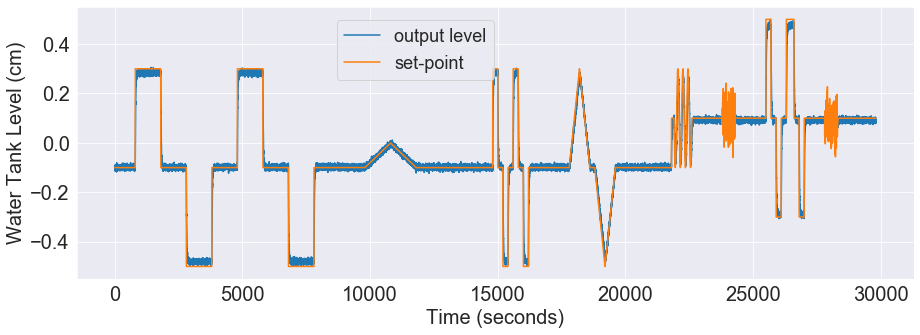

In [10]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean,label="output level");
plt.plot(X_clean[:,1],label="set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Water Tank Level (cm)", fontsize=20);
plt.xlabel("Time (seconds)", fontsize=20);
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

### Bandpass Potential Intervals

#### This method was implemented inspired by the idea in the following works:

<cite>ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly Stationary Historical Records for Multivariable System Identification. In: Proceedings of the 21st International Conference on System Theory, Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.</cite>

<cite>ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary data records to support system identification. In: Proceedings of the XXVI International Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo, Bosnia-Herzegovina: IEEE, 2017b.</cite>

In [11]:
sw = SlidingWindow(
            window_size=200, 
            H_v = [0.003,0.003], 
            min_input_coupling=1,
            min_output_coupling=1,
            num_previous_indexes=0,
            min_interval_length=None,
            n_jobs=-1, 
            verbose=0
        )

In [12]:
start = time()
sw.fit(X=df[['SP']], y=df[['Y']])
end = time()

In [13]:
print("Execution Time: {}".format(end-start))

Execution Time: 1.741353988647461


In [14]:
indicating_sequences = sw.unified_indicating_sequence
indicating_sequences[np.argwhere(indicating_sequences==1)]=0.5
indicating_sequences[np.argwhere(indicating_sequences==0)]=-0.5

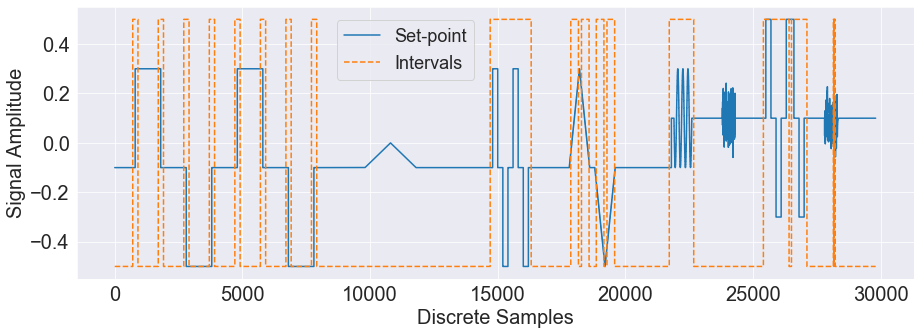

In [38]:
plt.figure(figsize=(15,5));
plt.step(range(0,df[['SP']].shape[0]),df[['SP']], label='Set-point');
plt.step(range(0,df[['SP']].shape[0]),indicating_sequences,linestyle='--', label='Intervals');
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);

### How the Method Works

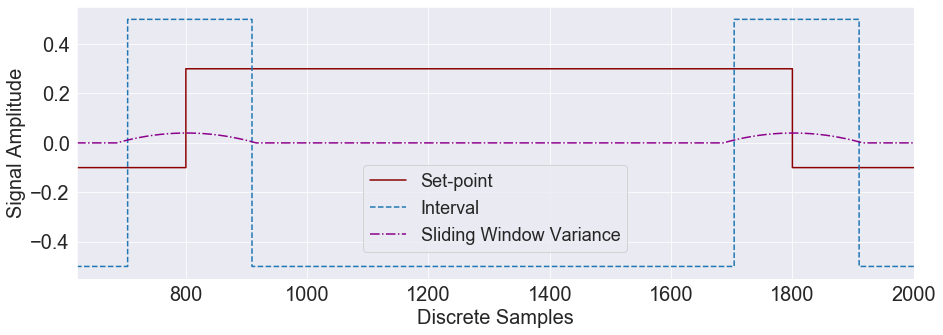

In [39]:
plt.figure(figsize=(15,5));
plt.step(range(0,df[['SP']].shape[0]),df[['SP']],color='darkred',label='Set-point');
plt.step(range(0,df[['SP']].shape[0]),indicating_sequences,linestyle='--',label='Interval');
plt.plot(sw.var_arr['SP'],color='darkmagenta',linestyle='-.',label='Sliding Window Variance');
plt.xlim([620,2000]);
plt.legend(bbox_to_anchor=(0.5, 0.45),fontsize=18);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);

### Impact of the Window Size

In [17]:
window_size_arr = list(range(10,200))
num_intervals = []

for window_size in window_size_arr:
    
    sw = SlidingWindow(
                window_size=window_size, 
                H_v = [0.003,0.002], 
                min_input_coupling=1,
                min_output_coupling=1,
                num_previous_indexes=0,
                min_interval_length=None,
                n_jobs=-1, 
                verbose=0
            )

    intervals = sw.fit(X=df[['SP']], 
                       y=df[['Y']])

    num_intervals.append(len(intervals.keys()))

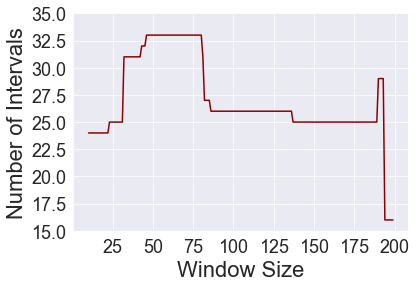

In [35]:
plt.plot(window_size_arr,num_intervals, color='darkred');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.ylim([15,35]);
plt.xlabel("Window Size", fontsize=22);
plt.ylabel("Number of Intervals", fontsize=22);

### Impact of the Window Size and Threshold

In [27]:
window_arr = np.arange(10,250,20)
thr_arr = [0.001, 0.002, 0.004, 0.008, 0.016, 0.04]

window_arr, thr_arr = np.meshgrid(window_arr, thr_arr)
num_intervals_mtx = np.zeros((window_arr.shape[0],window_arr.shape[1]))

counter = 0
for idx_1 in range(window_arr.shape[0]):
    for idx_2 in range(window_arr.shape[1]):
        
        counter+=1
        
        if counter%4==0:
            print("Iteration {}/{}".format(counter,window_arr.shape[0]*window_arr.shape[1]))
    
        window = window_arr[idx_1,idx_2]
        thr = thr_arr[idx_1,idx_2]
        

        sw = SlidingWindow(
                    window_size=window, 
                    H_v = [thr,thr], 
                    min_input_coupling=1,
                    min_output_coupling=1,
                    num_previous_indexes=0,
                    min_interval_length=None,
                    n_jobs=-1, 
                    verbose=0
                )
        
        intervals = sw.fit(X=df[['SP']],y=df[['Y']]);

        num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())

Iteration 4/108
Iteration 8/108
Iteration 12/108
Iteration 16/108
Iteration 20/108
Iteration 24/108
Iteration 28/108
Iteration 32/108
Iteration 36/108
Iteration 40/108
Iteration 44/108
Iteration 48/108
Iteration 52/108
Iteration 56/108
Iteration 60/108
Iteration 64/108
Iteration 68/108
Iteration 72/108
Iteration 76/108
Iteration 80/108
Iteration 84/108
Iteration 88/108
Iteration 92/108
Iteration 96/108
Iteration 100/108
Iteration 104/108
Iteration 108/108


In [32]:
import plotly.graph_objects as go
window_arr = np.arange(10,250,20)
thr_arr = [0.001, 0.002, 0.004, 0.008, 0.016, 0.04]

fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=window_arr, # horizontal axis
        y=thr_arr, # vertical axis,
        zmin=0,
        zmax=40,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Window Size } w_{s}$",
    yaxis_title=r"$\Large \text{Variance Threshold  } l_{S}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()